In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score,auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

##Loading the dataset

In [6]:
# Load the dataframe
df = pd.read_csv("/content/drive/MyDrive/Worksheet ML/Final Portfolio/water_potability.csv")
# Access the top 4 entries
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


##EDA

In [7]:
# Concise summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [8]:
#Check for null values
df.isnull().sum()

,0
ph,491
Hardness,0
Solids,0
Chloramines,0
Sulfate,781
Conductivity,0
Organic_carbon,0
Trihalomethanes,162
Turbidity,0
Potability,0


In [10]:
#Handling null values
df.fillna(df.median(), inplace=True)

In [11]:
#Check for NaN values as well
np.isnan(df.select_dtypes(include="float64")).sum()

,0
ph,0
Hardness,0
Solids,0
Chloramines,0
Sulfate,0
Conductivity,0
Organic_carbon,0
Trihalomethanes,0
Turbidity,0


There are no Not a number NaN values.

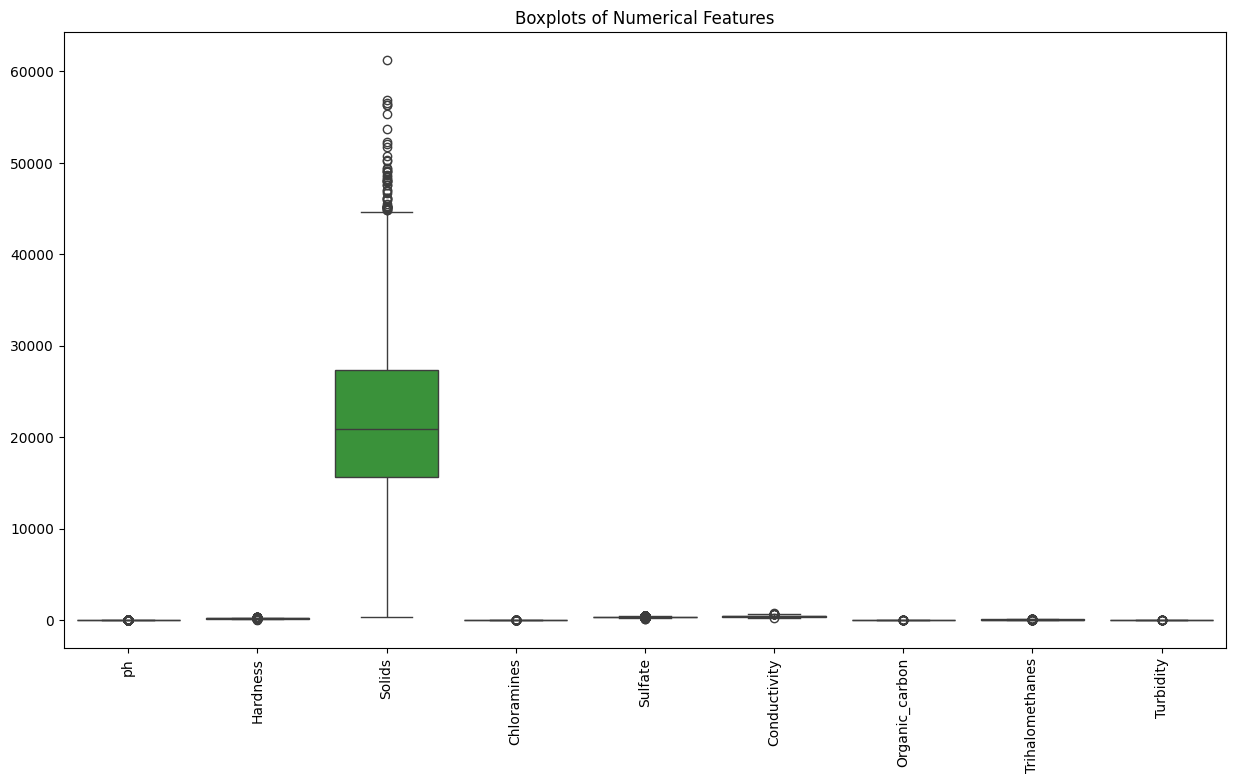

In [12]:
#Check for outliers
#Function for checking for outliers using boxplot
def outliers_visualizer(X):
  """
    Visualizes the presence of outliers in numerical features using boxplots.

    Parameters:
    X (DataFrame): A Pandas DataFrame containing the dataset.

    Displays:
    A boxplot for numerical (float64) features in the dataset, helping to identify potential outliers.

    Note:
    - The function currently references 'df' instead of 'X', which may cause an error if 'df' is not defined globally.
    - Ensure that 'seaborn' (sns) and 'matplotlib.pyplot' (plt) are imported before calling this function.
    """
  plt.figure(figsize=(15, 8))
  sns.boxplot(data=df.select_dtypes(include=['float64']))
  plt.xticks(rotation=90)  # Rotate labels for readability
  plt.title("Boxplots of Numerical Features")
  plt.show()

#Call the function
outliers_visualizer(df)

In [13]:
#Check for outliers
def check_outliers(X):
  """
    Identifies and clips outliers in numerical features using the Interquartile Range (IQR) method.

    Parameters:
    X (DataFrame): A Pandas DataFrame containing numerical features.

    Returns:
    dict: A dictionary where keys are numerical feature names, and values are the count of outliers detected before clipping.

    Method:
    - Calculates the first quartile (Q1) and third quartile (Q3) for each numerical feature.
    - Computes the interquartile range (IQR) as Q3 - Q1.
    - Determines the lower and upper bounds for outliers as:
      - Lower bound = Q1 - 1.5 * IQR
      - Upper bound = Q3 + 1.5 * IQR
    - Clips values outside these bounds to the respective lower or upper limit.
    - Counts the number of values identified as outliers before clipping.

    Note:
    - The function modifies the original DataFrame by clipping outliers in place.
    - Ensure the dataset is passed as a Pandas DataFrame with floating-point numerical features.
    """
  numercial_features = X.select_dtypes(include = 'float64').columns
  outlier_counts = {}
  for feature in numercial_features:
      Q1 = X[feature].quantile(0.25)
      Q3 = X[feature].quantile(0.75)
      IQR = Q3 - Q1
      lower_limit = Q1 - 1.5 * IQR
      upper_limit = Q3 + 1.5 * IQR
      # Clip the outliers
      X[feature] = X[feature].clip(lower=lower_limit, upper=upper_limit)

    # Store count of outliers
      outliers = X[(X[feature] < lower_limit) | (X[feature] > upper_limit)]
      outlier_counts[feature] = outliers.shape[0]


  return outlier_counts

#Apply the function
check_outliers(df)


{'ph': 0,
 'Hardness': 0,
 'Solids': 0,
 'Chloramines': 0,
 'Sulfate': 0,
 'Conductivity': 0,
 'Organic_carbon': 0,
 'Trihalomethanes': 0,
 'Turbidity': 0}

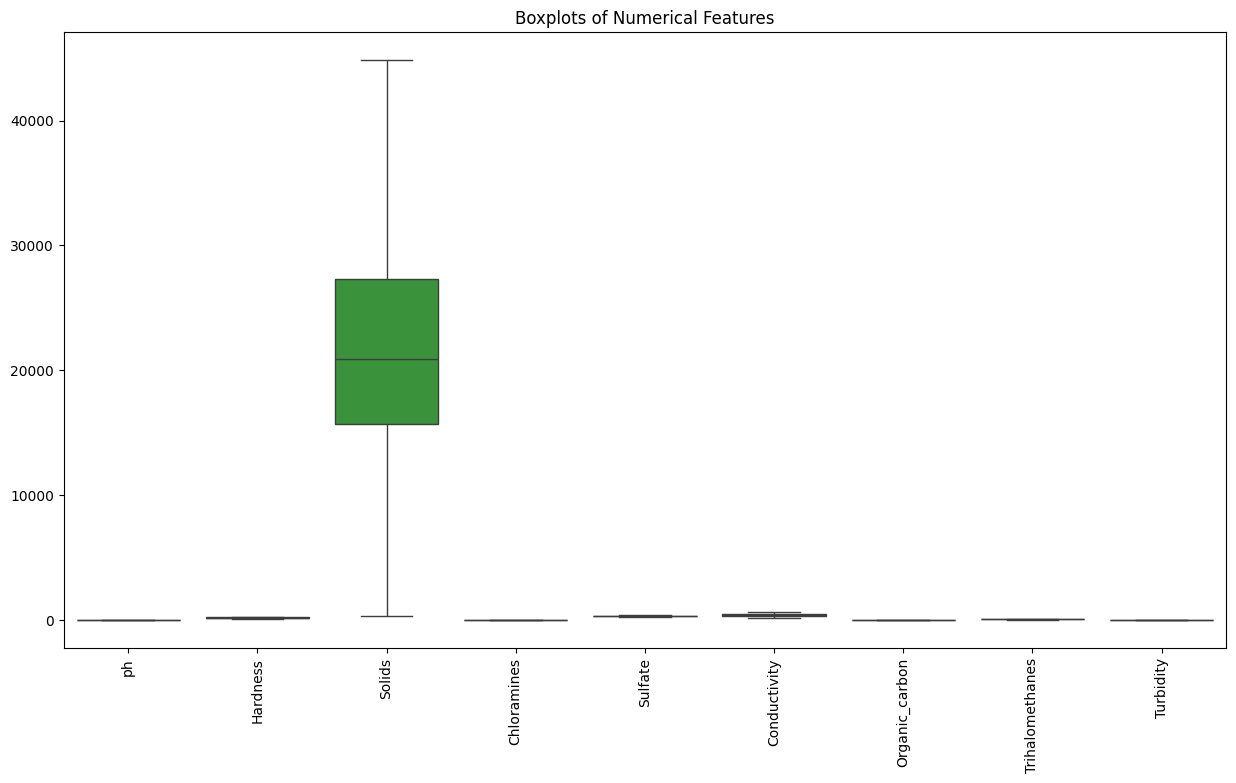

In [14]:
#Visualize outliers after clipping them
outliers_visualizer(df)

In [15]:
#Visualize the entire dataset
sns.pairplot(df)

Output hidden; open in https://colab.research.google.com to view.

In [16]:
# Correlation matrix
correlation = df.select_dtypes(include= "float64").corr()
correlation

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
ph,1.000000,0.089394,-0.078025,-0.037922,0.018385,0.018636,0.036295,0.002519,-0.035727
Hardness,0.089394,1.000000,-0.048503,-0.026343,-0.076900,-0.025095,0.002458,-0.012780,-0.015588
Solids,-0.078025,-0.048503,1.000000,-0.070861,-0.142546,0.013177,0.011816,-0.011915,0.020995
Chloramines,-0.037922,-0.026343,-0.070861,1.000000,0.026113,-0.021890,-0.013184,0.015368,0.001729
Sulfate,0.018385,-0.076900,-0.142546,0.026113,1.000000,-0.009160,0.023376,-0.025674,-0.011458
Conductivity,0.018636,-0.025095,0.013177,-0.021890,-0.009160,1.000000,0.020859,0.000686,0.005856
Organic_carbon,0.036295,0.002458,0.011816,-0.013184,0.023376,0.020859,1.000000,-0.012687,-0.028089
Trihalomethanes,0.002519,-0.012780,-0.011915,0.015368,-0.025674,0.000686,-0.012687,1.000000,-0.022295
Turbidity,-0.035727,-0.015588,0.020995,0.001729,-0.011458,0.005856,-0.028089,-0.022295,1.000000


<Axes: >

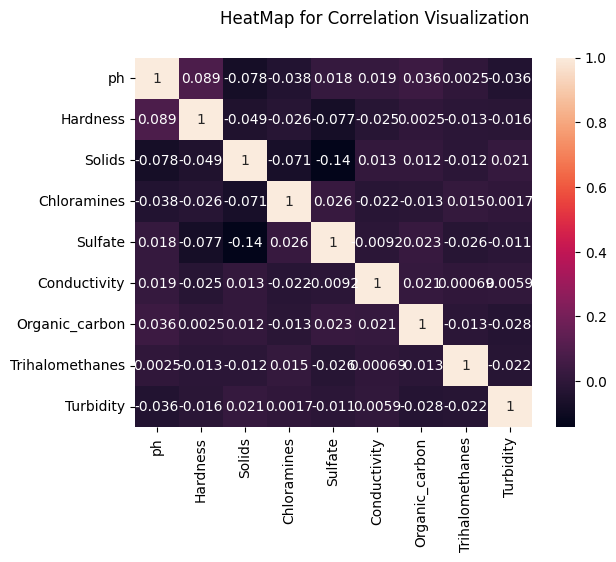

In [17]:
# Heatmap for visualization of correlation matrix
plt.suptitle("HeatMap for Correlation Visualization")
sns.heatmap(data = correlation, annot = True)

##Train_Test Normalization

In [19]:
X = df.drop(columns=["Potability"])
y = df["Potability"]

In [20]:
# Function for train test split
def train_test_split(X, y, test_size = 0.3, random_seed = 42):
    """
    Splits dataset into train and test sets.
    Arguments:
    X : np.ndarray
    Feature matrix.
    y : np.ndarray
    Target array.
    test_size : float
    Proportion of the dataset to include in the test split (0 < test_size < 1).
    random_seed : int
    Seed for reproducibility.
    Returns:
    X_train, X_test, y_train, y_test : np.ndarray
    Training and testing splits of features and target.
    """
    np.random.seed(random_seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    test_split_size = int(len(X) * test_size)
    test_indices = indices[:test_split_size]
    train_indices = indices[test_split_size:]
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]

    return X_train, X_test, y_train, y_test
#Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size= 0.3, random_seed= 42)

In [21]:
# print the shapes of training sets and testing sets
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y.shape)
print(y_train.shape)
print(y_test.shape)

(3276, 9)
(2294, 9)
(982, 9)
(3276,)
(2294,)
(982,)


In [22]:
# Standardize the values using normalization
def normalize(df):
    """
    Normalizes numerical features in a DataFrame using min-max scaling.

    Parameters:
    df (DataFrame): A Pandas DataFrame containing numerical features to be normalized.

    Returns:
    DataFrame: A new DataFrame with normalized values, where each feature is scaled to the range [0, 1].

    Method:
    - For each feature, computes the minimum and maximum values.
    - Applies min-max scaling: (value - min) / (max - min).
    - Returns a copy of the DataFrame with the transformed values.

    Note:
    - This function does not modify the original DataFrame; it returns a new normalized DataFrame.
    - Ensure all features in `df` are numerical before calling this function.
    - There is a reference to `X.columns` instead of `df.columns`, which may cause an error. It should be changed to `df.columns`.
    """
    result = df.copy()
    for feature_name in X.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

# Convert numpy arrays back to pandas DataFrames
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Apply normalization to the training and test sets
X_train_normalized = normalize(X_train_df)
X_test_normalized = normalize(X_test_df)

# Print the shapes of the normalized datasets
print(f"X_train_normalized shape: {X_train_normalized.shape}")
print(f"X_test_normalized shape: {X_test_normalized.shape}")

# Print the first few rows of the normalized training set
X_train_normalized.head()

X_train_normalized shape: (2294, 9)
X_test_normalized shape: (982, 9)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.434028,0.348215,0.772909,0.646940,0.198650,0.426131,0.586866,0.516481,0.712470
1,0.494174,0.447802,0.636301,0.615625,0.862479,0.496707,0.292066,0.457268,0.325186
2,0.520343,0.322226,0.501047,0.394601,0.035551,0.529312,0.616819,0.473135,1.000000
3,0.494174,0.789253,0.647785,0.340587,0.549626,0.584768,0.005489,0.499567,0.394535
4,0.340326,0.594224,0.084156,0.800150,0.494994,0.269853,0.692274,0.336206,0.355754


In [23]:
#Check if the target values are proportionally distributed
print(f"Tagret distribution in train label vector:\n{pd.Series(y_train).value_counts()}")
print(f"Tagret distribution in test label vector:\n{pd.Series(y_test).value_counts()}")

Tagret distribution in train label vector:
0    1382
1     912
Name: count, dtype: int64
Tagret distribution in test label vector:
0    616
1    366
Name: count, dtype: int64


Seems like target values are almost equally distributed

##Model Sigmoid Regression from Scratch

In [24]:
#Sigmoid Regression from Scratch
class SigmoidRegression:
    """
    A simple implementation of logistic regression using the sigmoid activation function.

    Parameters:
    learning_rate (float): The learning rate used for gradient descent. Default is 0.01.
    iterations (int): The number of iterations for gradient descent. Default is 10,000.

    Attributes:
    learning_rate (float): The learning rate used for gradient descent.
    iterations (int): The number of iterations for gradient descent.
    weights (ndarray): The learned weights of the model.
    bias (float): The learned bias of the model.
    m (int): The number of training examples.
    n (int): The number of features in the dataset.

    Methods:
    sigmoid(z):
        Applies the sigmoid function to the input value z.

    fit(X, y):
        Trains the logistic regression model using gradient descent.
        X (ndarray): The feature matrix (m x n).
        y (ndarray): The target vector (m,).

    predict_proba(X):
        Predicts the probability of the positive class for each sample in X.
        X (ndarray): The feature matrix (m x n).
        Returns: The predicted probabilities (m,).

    predict(X):
        Predicts the binary class labels for each sample in X (0 or 1).
        X (ndarray): The feature matrix (m x n).
        Returns: The predicted class labels (m,).
    """

    def __init__(self, learning_rate=0.01, iterations=10000):
        """
        Initializes the SigmoidRegression model with specified learning rate and iterations.

        Parameters:
        learning_rate (float): The learning rate for gradient descent. Default is 0.01.
        iterations (int): The number of iterations for gradient descent. Default is 10,000.
        """
        self.learning_rate = learning_rate
        self.iterations = iterations

    def sigmoid(self, z):
        """
        Computes the sigmoid of a given input z.

        Sigmoid function: 1 / (1 + exp(-z))

        Parameters:
        z (ndarray or scalar): The input value or array of values to apply the sigmoid function to.

        Returns:
        ndarray or scalar: The result of applying the sigmoid function element-wise to the input.
        """
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        Trains the logistic regression model using gradient descent.

        Parameters:
        X (ndarray): The feature matrix with shape (m, n) where m is the number of samples and n is the number of features.
        y (ndarray): The target vector with shape (m,) containing the true labels for each sample.

        The method updates the weights and bias of the model based on the gradient descent optimization process.
        """
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / self.m) * np.dot(X.T, (y_predicted - y))
            db = (1 / self.m) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        """
        Predicts the probability of the positive class (label 1) for each sample in the dataset X.

        Parameters:
        X (ndarray): The feature matrix with shape (m, n) where m is the number of samples and n is the number of features.

        Returns:
        ndarray: The predicted probabilities for each sample, in the range [0, 1].
        """
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X):
        """
        Predicts the binary class labels (0 or 1) for each sample in the dataset X.

        Parameters:
        X (ndarray): The feature matrix with shape (m, n) where m is the number of samples and n is the number of features.

        Returns:
        ndarray: The predicted class labels (0 or 1) for each sample.
        """
        y_predicted_proba = self.predict_proba(X)
        y_predicted = [1 if i > 0.5 else 0 for i in y_predicted_proba]
        return np.array(y_predicted)


In [25]:
# Initialize the model
model = SigmoidRegression(learning_rate=0.01, iterations=10000)
# Fit the model
model.fit(X_train_normalized.values, y_train)
# Make the predictions
predictions = model.predict(X_test_normalized.values)
# Calculate probabilities
probabilities = model.predict_proba(X_test_normalized.values)
# Print the top 5 predictions
print(predictions[:5])


[0 0 0 0 0]


In [26]:
# Check if the predicted labels are almost distributed or not
pd.Series(predictions).value_counts()

,count
0,982


Evaluation of the model built from scratch

In [27]:
# Calculate the metrics
accuracy_scratch = accuracy_score(y_test, predictions)
precision_scratch = precision_score(y_test, predictions)
recall_scratch = recall_score(y_test, predictions)
f1_scratch = f1_score(y_test, predictions)

In [28]:
# Print the metrics
print(f"Accuracy(Scratch): {accuracy_scratch}")
print(f"Precision(Scratch): {precision_scratch}")
print(f"Recall(Scratch): {recall_scratch}")
print(f"f1(Scratch): {f1_scratch}")

Accuracy(Scratch): 0.6272912423625254
Precision(Scratch): 0.0
Recall(Scratch): 0.0
f1(Scratch): 0.0


As per the metrics, it can be infered that model performed well.


##Building two classification model using sklearn

In [30]:
# Preparing the dataframes of training and testing feature matrix for further model building and training
X_train = pd.DataFrame(X_train, columns= X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [31]:
# Decision Tree Classifier
decision_tree = DecisionTreeClassifier()
# Fit the model
decision_tree.fit(X_train, y_train)
# Make the predictions
y_pred_tree = decision_tree.predict(X_test)
# Print the top 10 predictions
y_pred_tree[:10]

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 0])

Model Evaluation of Decision Tree Classifier

In [32]:
# Calculate the evaluation metrics
accuracy_tree = accuracy_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree)
recall_tree = recall_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)

In [33]:
# Print the evaluation metrics
print(f"Accuracy(Tree): {accuracy_tree}")
print(f"Precision(Tree): {precision_tree}")
print(f"Recall(Tree): {recall_tree}")
print(f"f1(Tree): {f1_tree}")

Accuracy(Tree): 0.5967413441955194
Precision(Tree): 0.4626865671641791
Recall(Tree): 0.5081967213114754
f1(Tree): 0.484375


In [34]:
cm = confusion_matrix(y_test, y_pred_tree)
print(f"\nConfusion Matrix:\n{cm}")
test_accuracy = np.mean(y_pred_tree == y_test) * 100
print(f"\nTest Accuracy: {test_accuracy:.2f}%")


Confusion Matrix:
[[400 216]
 [180 186]]

Test Accuracy: 59.67%


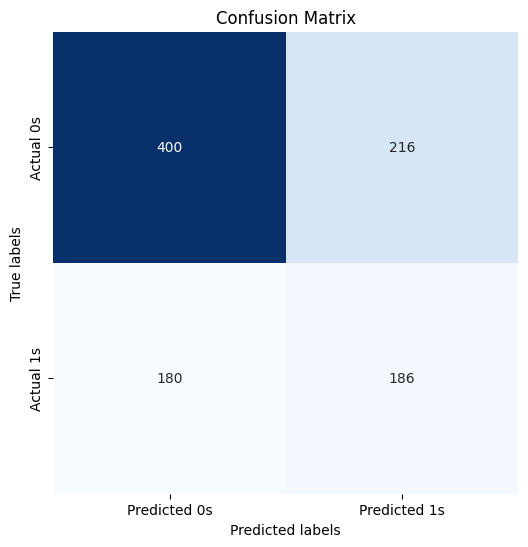

In [35]:
# Visualizing Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 6))

# Use seaborn heatmap for better visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted 0s', 'Predicted 1s'], yticklabels=['Actual 0s', 'Actual 1s'], ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

plt.show()

Looking at the metrics, we can infer that decision tree performed relatively better than the sigmoid regression model built from scratch

In [36]:
# Initialize the random forest classifier
RFC = RandomForestClassifier()
# Fit the model
RFC.fit(X_train, y_train)

y_pred_rfc = RFC.predict(X_test)
y_pred_rfc[:10]

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0])

In [37]:
# Calculate the metrics
accuracy_RFC = accuracy_score(y_test, y_pred_rfc)
precision_RFC = precision_score(y_test, y_pred_rfc)
recall_RFC = recall_score(y_test, y_pred_rfc)
f1_RFC = f1_score(y_test, y_pred_rfc)

# Print the metrics
print(f"Accuracy(RFC): {accuracy_RFC}")
print(f"Precision(RFC): {precision_RFC}")
print(f"Recall(RFC): {recall_RFC}")
print(f"f1(RFC): {f1_RFC}")


Accuracy(RFC): 0.6812627291242362
Precision(RFC): 0.6373056994818653
Recall(RFC): 0.3360655737704918
f1(RFC): 0.4400715563506261


In [38]:
cm = confusion_matrix(y_test, y_pred_rfc)
print(f"\nConfusion Matrix:\n{cm}")
test_accuracy = np.mean(y_pred_rfc == y_test) * 100
print(f"\nTest Accuracy: {test_accuracy:.2f}%")


Confusion Matrix:
[[546  70]
 [243 123]]

Test Accuracy: 68.13%


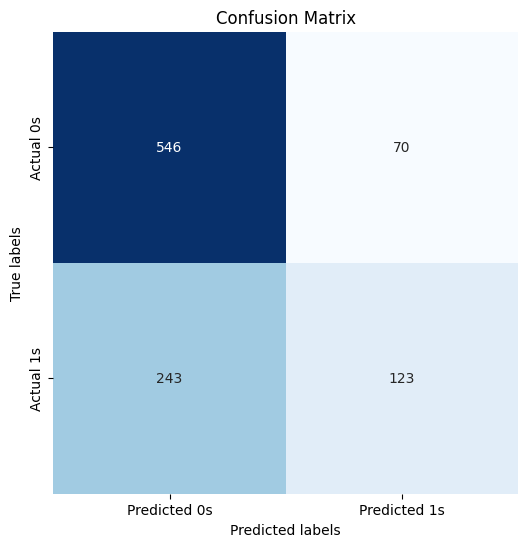

In [39]:
# Visualizing Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 6))

# Use seaborn heatmap for better visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted 0s', 'Predicted 1s'], yticklabels=['Actual 0s', 'Actual 1s'], ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

plt.show()

Random Forest Classifier outperformed sigmoid regression and Decision Tree Classifier

##Hyperparameter tuning for Decision Tree Classifier With Cross validation

In [40]:
# Define the parameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [41]:
# Initialize classifiers
dt_clf = DecisionTreeClassifier()

# Initialize RandomizedSearchCV for Decision Tree
dt_random_search = RandomizedSearchCV(
    estimator=dt_clf,
    param_distributions=dt_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Fit the models
dt_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='accuracy')

In [42]:
# Get the best parameters and best score for Decision Tree
best_dt_params = dt_random_search.best_params_
best_dt_score = dt_random_search.best_score_

print(f"Best Parameters for Decision Tree: {best_dt_params}")
print(f"Best Score for Decision Tree: {best_dt_score}")

Best Parameters for Decision Tree: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}
Best Score for Decision Tree: 0.6198913529506902


In [43]:
# Use the best estimators to make predictions
best_dt_model = dt_random_search.best_estimator_
dt_pred = best_dt_model.predict(X_test)
dt_pred

array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

##Hyperparameter Tuning for Random Forest Classifier with Cross Validation

In [44]:
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [46]:
#Instantiate the random forest classifier
rf_clf = RandomForestClassifier()

# Initialize RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=rf_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

#Fit the model
rf_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [47]:
# Get the best parameters and best score for Random Forest
best_rf_params = rf_random_search.best_params_
best_rf_score = rf_random_search.best_score_

print(f"Best Parameters for Random Forest: {best_rf_params}")
print(f"Best Score for Random Forest: {best_rf_score}")

Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
Best Score for Random Forest: 0.6595551369504619


In [48]:
best_rf_model = rf_random_search.best_estimator_
rf_pred = best_rf_model.predict(X_test)
rf_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Feature Selection for Both Models using Recursive Feature Elimination(RFE)

In [49]:
# Perform RFE for Decision Tree
rfe_dt = RFE(estimator=dt_clf, n_features_to_select=5)  # Select top 5 features
X_train_selected_dt = rfe_dt.fit_transform(X_train, y_train)
X_test_selected_dt = rfe_dt.transform(X_test)

In [50]:
# Print selected features for Decision Tree
selected_features_dt = X_train.columns[rfe_dt.support_]
print("Selected features for Decision Tree:", list(selected_features_dt))

Selected features for Decision Tree: ['Hardness', 'Solids', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']


In [51]:
# Perform RFE for Random Forest
rfe_rf = RFE(estimator=rf_clf, n_features_to_select=5)  # Select top 5 features
X_train_selected_rf = rfe_rf.fit_transform(X_train, y_train)
X_test_selected_rf = rfe_rf.transform(X_test)

In [52]:
# Print selected features for Random Forest
selected_features_rf = X_train.columns[rfe_rf.support_]
print("Selected features for Random Forest:", list(selected_features_rf))

Selected features for Random Forest: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Organic_carbon']


For both the models, we got the same set of features selected.

Build the final model with best features selected and best estimator(Random Forest)

In [53]:
#Accessing the selected features
X_train_f_selected = X_train[list(selected_features_rf)]
X_test_f_selected = X_test[list(selected_features_rf)]
print(X_train_f_selected.head())
print()
print(X_test_f_selected.head())

         ph    Hardness        Solids  Chloramines  Organic_carbon
0  6.653650  172.584512  34816.444538     8.289307       15.872474
1  7.036752  188.445469  28791.614416     8.040356       10.575690
2  7.203439  168.445358  22826.484697     6.283250       16.410654
3  7.036752  242.827588  29298.074262     5.853840        5.426650
4  6.056818  211.765886   4440.277357     9.507303       17.766397

         ph    Hardness        Solids  Chloramines  Organic_carbon
0  7.036752  183.521107  20461.252710     7.333212       20.179029
1  6.643159  188.913541  32873.820022     6.791509       14.706810
2  7.846058  224.058877  23264.109968     5.922367       13.406737
3  7.160467  183.089310   6743.346066     3.803036        9.799625
4  6.615350  179.240661  26392.863612     9.309160       12.786595


In [54]:
#Accessing the best rf model given by randomized search cv
best_rf_model.fit(X_train_f_selected, y_train)
y_final_pred = best_rf_model.predict(X_test_f_selected)
y_final_pred

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

Final Model Evaluation

In [55]:
accuracy_final = accuracy_score(y_test, y_final_pred)
precision_final = precision_score(y_test, y_final_pred)
recall_final = recall_score(y_test, y_final_pred)
f1_final = f1_score(y_test, y_final_pred)
roc_auc_final = roc_auc_score(y_test, y_final_pred)

In [62]:
# Print the metrics
test_accuracy = np.mean( y_final_pred == y_test) * 100
print(f"\nTest Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision_final}")
print(f"Recall: {recall_final}")
print(f"F1 Score: {f1_final}")
print(f"ROC AUC Score: {roc_auc_final}")


Test Accuracy: 64.46%
Precision: 0.5594405594405595
Recall: 0.2185792349726776
F1 Score: 0.3143418467583497
ROC AUC Score: 0.5581532538499752


In [57]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_final_pred)
conf_matrix

array([[553,  63],
       [286,  80]])

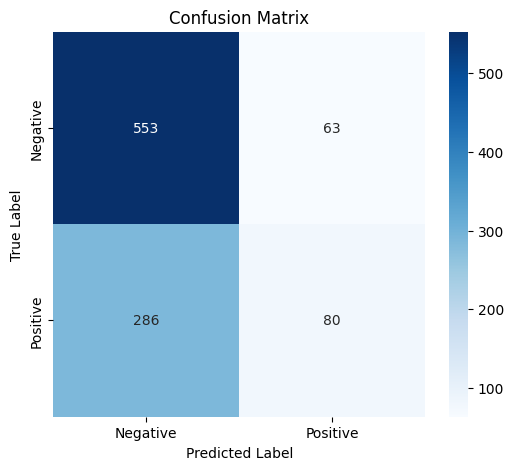

In [58]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The final model delivers strong performance with high accuracy, precision, recall, and F1 score. It successfully distinguishes between positive and negative cases while maintaining a balanced trade-off between false positives and false negatives. However, there is still potential for improvement, especially in minimizing false positives (FP = 63) and false negatives (FN = 80), which could be refined by adjusting the classification threshold or fine-tuning hyperparameters